In [1]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 1

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

d:\alex\code\machine-learning\env36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\alex\code\machine-learning\env36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\alex\code\machine-learning\env36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\alex\code\machine-learning\env36\lib\site-packages\tensorflow\python\f

In [2]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
from datetime import datetime
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

In [3]:
df = pd.read_csv("train.csv")
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
onehot = OneHotEncoder(handle_unknown='ignore')
onehot.fit(df[["label"]])
cat_list = np.concatenate(onehot.categories_)
df[cat_list] = pd.DataFrame(onehot.transform(df[["label"]]).toarray(), index=df.index)

In [5]:
X = df.drop(columns=cat_list)
X = X.drop(columns=["label"])
X = X / 255
y = df[cat_list].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train = X_train.to_numpy().reshape(-1,28,28,1)
X_test = X_test.to_numpy().reshape(-1,28,28,1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(33600, 28, 28, 1) (33600, 10)
(8400, 28, 28, 1) (8400, 10)


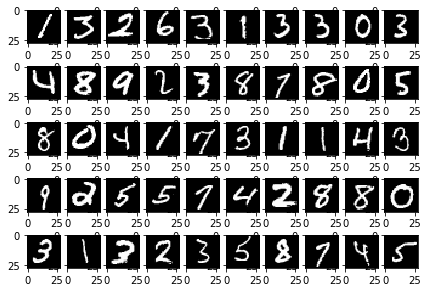

In [21]:
_, axs = plt.subplots(5, 10, figsize=(7, 5))
axs = axs.flatten()
for i in range(len(axs)):
    axs[i].imshow(np.squeeze(X_train[i]), cmap=plt.get_cmap('gray'))

In [7]:
class LogUniform:
    def __init__(self, low, high):
        self.low = low
        self.high = high
    
    def rvs(self, *args, **kwds):
        return 10 ** np.random.uniform(np.log10(self.low), np.log10(self.high))

In [8]:
def create_model(learning_rate, units, rate=0, hidden_layers=1):
    # cleanup
    K.clear_session()
    
    model = Sequential()
    model.add(Conv2D(8, kernel_size=4, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(rate))
    model.add(Flatten())
    model.add(Dense(units=units, activation='relu'))
    model.add(Dropout(rate))
    model.add(Dense(units=10, activation="softmax"))
    model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate),
              metrics=['accuracy'])
    
    return model


# model = KerasClassifier(build_fn=create_model, epochs=10)
# param_dist = {"learning_rate": LogUniform(0.0001, 0.01),
#               "rate": uniform(0.1, 0.5),
#               "units": randint(50, 200),
#               "batch_size": [32, 64, 128],
#              }
# clf = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_jobs=1, cv=5, n_iter=20, verbose=100)
# clf.fit(X_train, y_train)


reg = 0
clf = Sequential()
clf.add(Conv2D(32, kernel_size=4, activation='relu', input_shape=(28, 28, 1)))
clf.add(MaxPooling2D())
clf.add(Dropout(reg))
clf.add(Flatten())
clf.add(Dense(200, activation='relu'))
clf.add(Dropout(reg))
clf.add(Dense(10, activation='softmax'))

clf.compile(loss='categorical_crossentropy',
          optimizer=Adam(0.003),
          metrics=['accuracy'])

print(clf.summary())







Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 25, 25, 32)        544       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               921800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)         

In [9]:
datagen = ImageDataGenerator(
    rotation_range=90,
    zoom_range=0.1)

batch_size = 32
clf.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train) / batch_size, epochs=10)

# clf.fit(X_train, y_train, epochs=10, batch_size=batch_size)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/10
1050/1050 [==============================] - 38s 36ms/step - loss: 0.3830 - acc: 0.8784
Epoch 2/10
1050/1050 [==============================] - 37s 35ms/step - loss: 0.1661 - acc: 0.9481
Epoch 3/10
1050/1050 [==============================] - 37s 35ms/step - loss: 0.1371 - acc: 0.9578
Epoch 4/10
1050/1050 [==============================] - 37s 36ms/step - loss: 0.1225 - acc: 0.9612
Epoch 5/10
1050/1050 [==============================] - 37s 35ms/step - loss: 0.1096 - acc: 0.9658
Epoch 6/10
1050/1050 [==============================] - 37s 35ms/step - loss: 0.1019 - acc: 0.9688
Epoch 7/10
1050/1050 [==============================] - 37s 35ms/step - loss: 0.1008 - acc: 0.9700
Epoch 8/10
1050/1050 [==============================] - 38s 36ms/step - loss: 0.0948 - acc: 0.9703
Epoch 9/10
1050/1050 [==============================] - 37s 35ms/step - loss: 0.0843 - acc: 0.9742
Epoch 10/10
10

In [10]:
train_loss_and_metrics = clf.evaluate(X_train, y_train)
test_loss_and_metrics = clf.evaluate(X_test, y_test)
print(train_loss_and_metrics, test_loss_and_metrics)

# print(clf.best_params_)
# train_score = clf.score(X_train, y_train)
# test_score = clf.score(X_test, y_test)
# print(train_score, test_score)

# 0.003 LR with image augmentation
#[0.09707930467113675, 0.9690773809523809] [0.11501840223425201, 0.9658333333333333]

# 8 Conv filters
#[0.08267584742157764, 0.9741666666666666] [0.10439852295665158, 0.9709523809523809]

# 32 filters
#[0.07321419805738212, 0.9794345238095238] [0.1007269965491945, 0.976547619047619]

# 32 filters, 20 epochs
#[0.049917013627720865, 0.9864880952380952] [0.08408450455239204, 0.9791666666666666]

# 30 epochs
#[0.06802647756706555, 0.9825297619047619] [0.12614248357675717, 0.9738095238095238]


8400/8400 [==============================] - 2s 246us/step
[0.08980474914807322, 0.9743154761904762] [0.11266928609798751, 0.9714285714285714]


In [11]:
df_test = pd.read_csv("test.csv")
df_test = df_test / 255
predictions = clf.predict(df_test.to_numpy().reshape(-1,28,28,1))
predictions = np.squeeze(onehot.inverse_transform(predictions))
df_submit = pd.DataFrame({'ImageId': list(range(1, 28001)), 'Label': predictions})
df_submit.to_csv('submission.csv', index=False)

In [12]:
test_pred_int = np.argmax(clf.predict(X_test), axis=1)
y_test_int = np.argmax(y_test, axis=1)
print(test_pred_int.shape, y_test_int.shape)
indices = [i for i,v in enumerate(test_pred_int) if test_pred_int[i] != y_test_int[i]]
wrong_pred = [X_test[i] for i in indices ]
print(len(wrong_pred))

(8400,) (8400,)
240


d:\alex\code\machine-learning\env36\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


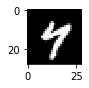

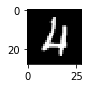

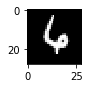

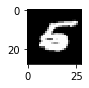

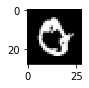

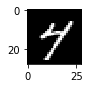

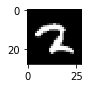

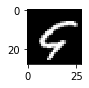

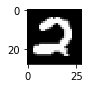

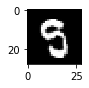

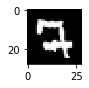

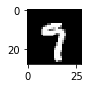

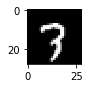

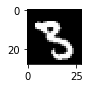

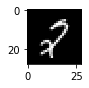

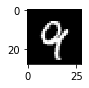

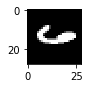

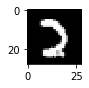

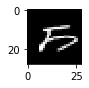

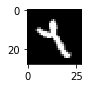

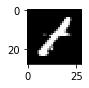

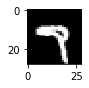

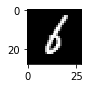

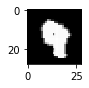

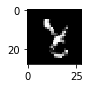

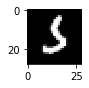

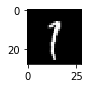

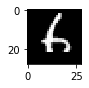

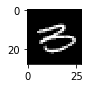

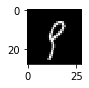

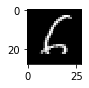

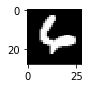

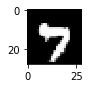

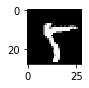

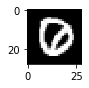

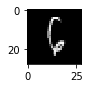

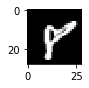

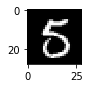

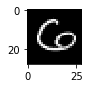

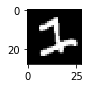

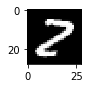

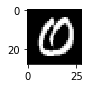

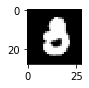

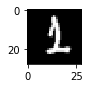

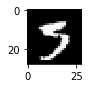

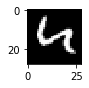

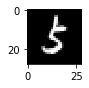

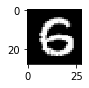

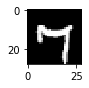

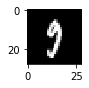

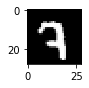

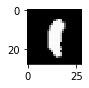

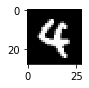

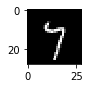

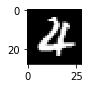

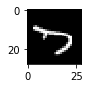

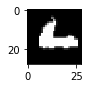

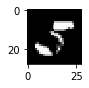

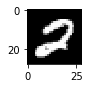

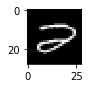

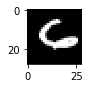

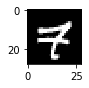

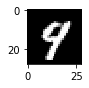

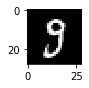

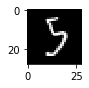

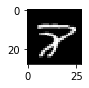

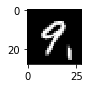

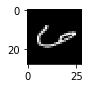

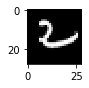

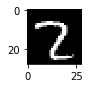

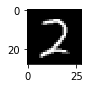

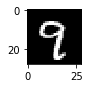

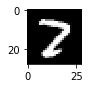

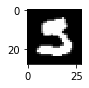

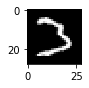

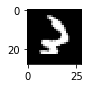

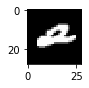

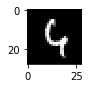

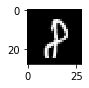

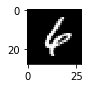

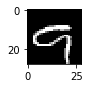

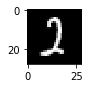

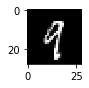

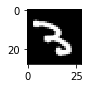

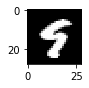

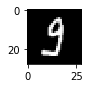

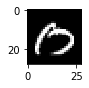

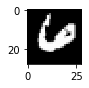

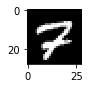

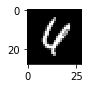

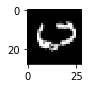

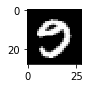

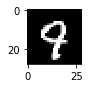

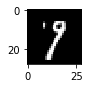

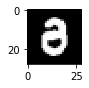

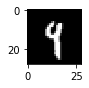

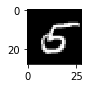

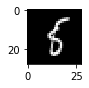

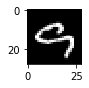

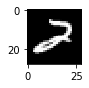

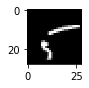

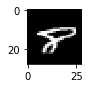

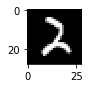

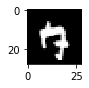

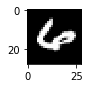

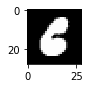

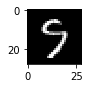

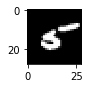

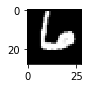

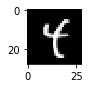

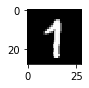

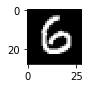

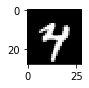

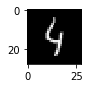

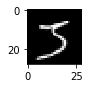

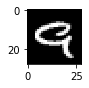

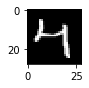

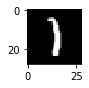

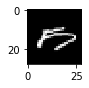

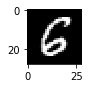

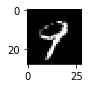

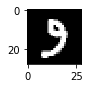

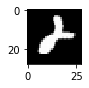

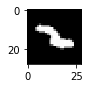

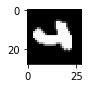

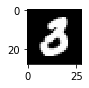

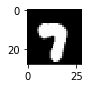

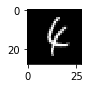

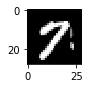

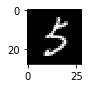

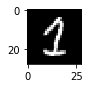

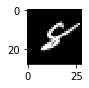

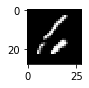

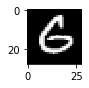

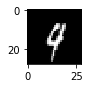

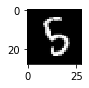

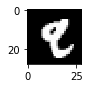

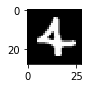

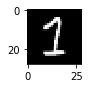

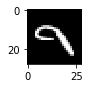

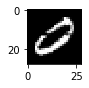

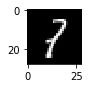

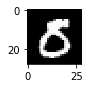

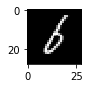

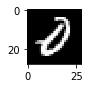

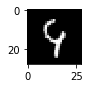

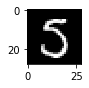

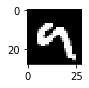

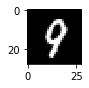

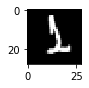

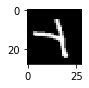

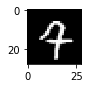

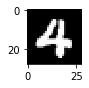

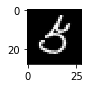

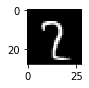

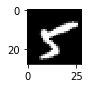

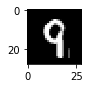

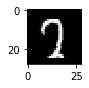

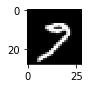

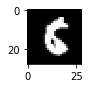

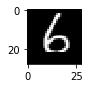

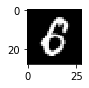

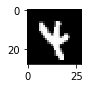

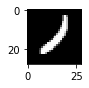

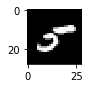

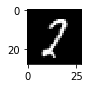

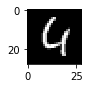

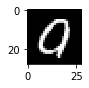

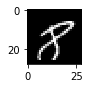

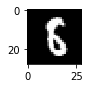

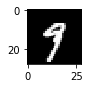

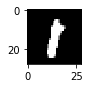

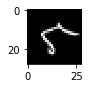

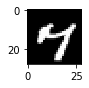

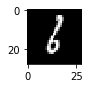

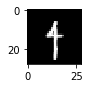

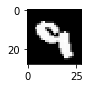

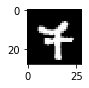

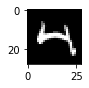

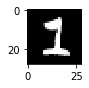

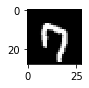

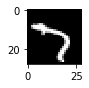

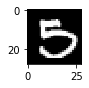

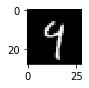

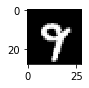

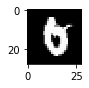

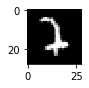

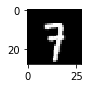

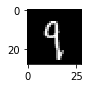

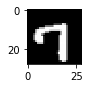

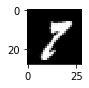

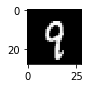

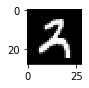

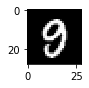

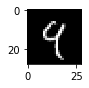

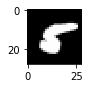

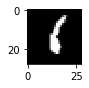

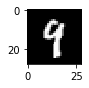

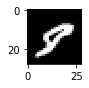

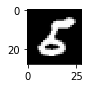

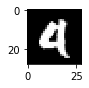

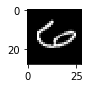

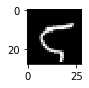

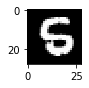

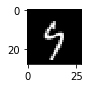

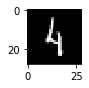

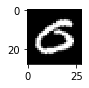

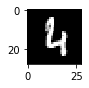

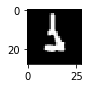

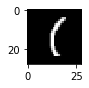

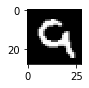

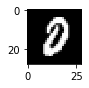

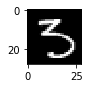

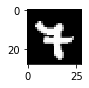

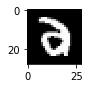

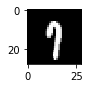

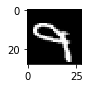

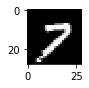

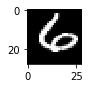

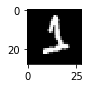

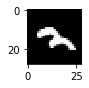

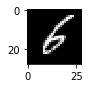

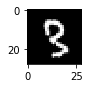

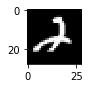

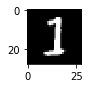

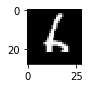

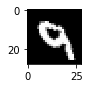

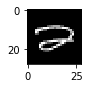

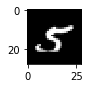

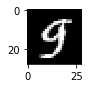

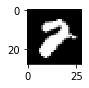

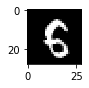

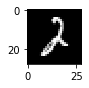

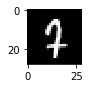

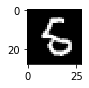

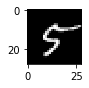

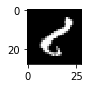

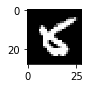

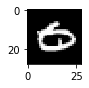

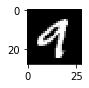

In [13]:
def display(images):
    for img in images:
        plt.figure(figsize=(1, 1))
        plt.imshow(np.squeeze(img), cmap=plt.get_cmap('gray'))
        
        
display(wrong_pred)